### Import Necessary Dependencies

In [56]:
#Import libraries

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(0)

%matplotlib inline
plt.style.use('seaborn')

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/Filip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read and Load the Dataset

In [37]:
# Upload datasets
df = pd.read_csv('tweet_product_company.csv', encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Exploratory Data Analysis

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [39]:
len(df.emotion_in_tweet_is_directed_at.unique())

10

In [40]:
df.columns = ['tweet_text', 'product', 'label']
df.head()

,tweet_text,product,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [41]:
df.tweet_text[0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [42]:
for column in df.columns[1:]:
    print('Column: ', column)
    print('Unique values count:', len(df[column].unique()))
    print('Values: ', df[column].unique())
    print('----------------')

Column:  product
Unique values count: 10
Values:  ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
----------------
Column:  label
Unique values count: 4
Values:  ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
----------------


In [43]:
# Create summary of Nan and unique values counts and data types
X_info = pd.DataFrame(df.isna().sum(), columns=['NaN count'])

unique_val = []
types_val = []
zero_val = []

for column in df.columns:
    unique = df[column].nunique()
    types = str(df[column].dtype)
    zeros = len(df[df[column]==0])
    
    unique_val.append(unique)
    types_val.append(types)
    zero_val.append(zeros)

X_info['Zero values count'] = zero_val
X_info['Unique_val count'] = unique_val
X_info['Data type'] = types_val

X_info.sort_values(by=['NaN count', 'Zero values count'], ascending=False)

,NaN count,Zero values count,Unique_val count,Data type
product,5802,0,9,object
tweet_text,1,0,9065,object
label,0,0,4,object


### Data Visualization of Target Variables

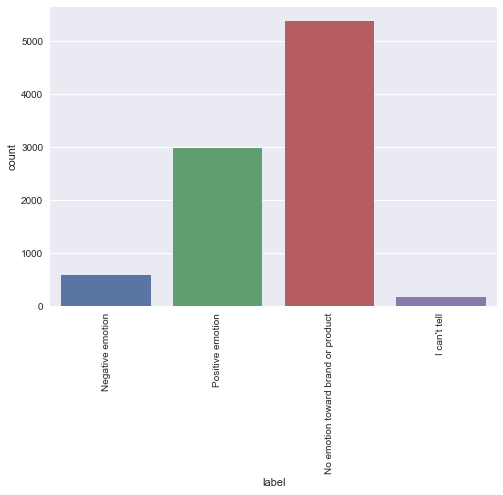

In [44]:
ax = sns.countplot(x='label', data=df)
ax.tick_params(axis='x', rotation=90)

In [86]:
df['label'].value_counts(normalize=True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327541
Negative emotion                      0.062692
I can't tell                          0.017158
Name: label, dtype: float64

### Cleaning and Preprocessing Data

#### Dropping a NaN values for 'tweet_text' column

- Do we remove stop words or not?
- Do we stem or lemmatize our text data, or leave the words as is?
- Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
- Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
- Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
- What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

In [57]:
df.dropna(subset=['tweet_text'], axis='rows', inplace=True)

#### Break apart the data and the labels, and then inspect the class names

In [58]:
data = df['tweet_text']
target = df['label']
label_names = list(target.unique())

In [59]:
label_names

['Negative emotion',
 'Positive emotion',
 'No emotion toward brand or product',
 "I can't tell"]

In [60]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

#### Getting a list of all of the english stopwords, and concatenating them with a list of all the punctuation.

In [61]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

#### Tokenizing our dataset

In [62]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed    

In [63]:
processed_data = list(map(process_tweet, X_train))

In [64]:
processed_data[:2]

[['perfect',
  'attention',
  'detail',
  'rt',
  'mention',
  'google',
  'recreated',
  'code',
  'pac-man',
  'doodle',
  'original',
  'bugs',
  'included',
  'sxsw',
  'googledoodles'],
 ['iphone', 'stolen', 'got', 'back', 'sxsw']]

#### Getting the total vocabulary size of the training dataset

In [65]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

9333

#### Exploring Data With Frequency Distributions

- Creating a frequency distribution to see which words are used the most!

In [66]:
tweets_concat = []
for tweet in processed_data:
    tweets_concat += tweet

In [67]:
tweets_freqdist = FreqDist(tweets_concat)
tweets_freqdist.most_common(50)

[('sxsw', 7149),
 ('mention', 5289),
 ('link', 3211),
 ('rt', 2194),
 ('google', 1973),
 ('ipad', 1824),
 ('apple', 1739),
 ('quot', 1256),
 ('iphone', 1140),
 ('store', 1127),
 ("'s", 929),
 ('2', 841),
 ('new', 802),
 ('austin', 715),
 ('amp', 644),
 ('app', 609),
 ('launch', 505),
 ('social', 496),
 ('circles', 492),
 ('today', 443),
 ('android', 438),
 ("n't", 366),
 ('network', 360),
 ('ipad2', 354),
 ('pop-up', 331),
 ('via', 318),
 ('line', 306),
 ('free', 291),
 ('called', 281),
 ('get', 277),
 ('party', 254),
 ('sxswi', 254),
 ('mobile', 249),
 ('one', 236),
 ('major', 232),
 ('time', 207),
 ("'re", 206),
 ('like', 206),
 ("'m", 199),
 ('opening', 199),
 ('temporary', 197),
 ('possibly', 184),
 ('people', 174),
 ('apps', 173),
 ('maps', 170),
 ('popup', 167),
 ('downtown', 167),
 ('day', 166),
 ('great', 166),
 ('going', 165)]

At first glance, none of these words seem very informative -- for most of the words represented here, it would be tough to guess if a given word is used equally among all five classes, or is disproportionately represented among a single class.

#### Vectorizing with TF-IDF

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

tf_idf_data_train = vectorizer.fit_transform(X_train)
tf_idf_data_test = vectorizer.transform(X_test)

#### Modeling Data

In [69]:
tf_idf_data_test.shape

(2273, 8643)

In [70]:
tf_idf_data_train.shape

(6819, 8643)

Checking out the average number of non-zero columns in the vectors. Vectors mostly filled with zeros are referred to as Sparse Vectors.

In [71]:
non_zero_cols = tf_idf_data_train.nnz / float(tf_idf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Tweets: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tf_idf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Tweets: 16.301070538202083
Percentage of columns containing 0: 0.9981139568971188


Average vectorized article contains 16 non-zero columns. This means that 99.8% of each vector is actually zeroes.

In [72]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

In [73]:
nb_classifier.fit(tf_idf_data_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [74]:
rf_classifier.fit(tf_idf_data_train, y_train)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [75]:
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)
rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.7246 		 Testing Accuracy: 0.6282

----------------------------------------------------------------------

Random Forest
Training Accuracy: 0.9962 		 Testing Accuracy: 0.6621


#### Multinomial Naive Bayes

In [76]:
%%time
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_names))

accuracy 0.6282446106467224
                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00        39
                  Positive emotion       0.00      0.00      0.00       151
No emotion toward brand or product       0.62      0.96      0.75      1320
                      I can't tell       0.71      0.21      0.32       763

                          accuracy                           0.63      2273
                         macro avg       0.33      0.29      0.27      2273
                      weighted avg       0.60      0.63      0.54      2273

CPU times: user 445 ms, sys: 11.3 ms, total: 456 ms
Wall time: 342 ms


In [84]:
%%time
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])

nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_names))

accuracy 0.6282446106467224
                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00        39
                  Positive emotion       0.00      0.00      0.00       151
No emotion toward brand or product       0.62      0.96      0.75      1320
                      I can't tell       0.71      0.21      0.32       763

                          accuracy                           0.63      2273
                         macro avg       0.33      0.29      0.27      2273
                      weighted avg       0.60      0.63      0.54      2273

CPU times: user 456 ms, sys: 40.2 ms, total: 496 ms
Wall time: 398 ms


#### Linear Support Vector Machine

In [186]:
%%time
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_names))

accuracy 0.6141663000439948
                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00        39
                  Positive emotion       0.00      0.00      0.00       151
No emotion toward brand or product       0.60      0.99      0.75      1320
                      I can't tell       0.82      0.12      0.20       763

                          accuracy                           0.61      2273
                         macro avg       0.36      0.28      0.24      2273
                      weighted avg       0.63      0.61      0.50      2273

CPU times: user 486 ms, sys: 12.6 ms, total: 498 ms
Wall time: 387 ms


#### Logistic Regression

In [85]:
%%time
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_names))

accuracy 0.6339639243290806
                                    precision    recall  f1-score   support

                  Negative emotion       0.07      0.03      0.04        39
                  Positive emotion       0.45      0.33      0.38       151
No emotion toward brand or product       0.70      0.74      0.72      1320
                      I can't tell       0.55      0.54      0.54       763

                          accuracy                           0.63      2273
                         macro avg       0.44      0.41      0.42      2273
                      weighted avg       0.62      0.63      0.63      2273

CPU times: user 2.18 s, sys: 145 ms, total: 2.32 s
Wall time: 2.58 s


### Keras

In [87]:
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

#### One-hot encoding of the complaints

Our first step again is to transform our textual data into a numerical representation. As we saw in some of our previous lessons on NLP, there are many ways to do this. Here, we'll use the Tokenizer() class from the preprocessing.text sub-module of the Keras package.

As with our previous work using NLTK, this will transform our text complaints into word vectors. (Note that the method of creating a vector is different from our previous work with NLTK; as you'll see, word order will be preserved as opposed to a bag of words representation). In the below code, we'll only keep the 2,000 most common words and use one-hot encoding.

In [88]:
# Raw text tweets
tweets = df['tweet_text']
# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=2000) 

# Fit it to the complaints
tokenizer.fit_on_texts(tweets) 

# Generate sequences
sequences = tokenizer.texts_to_sequences(tweets) 
print('sequences type:', type(sequences))

# Similar to sequences, but returns a numpy array
one_hot_results= tokenizer.texts_to_matrix(tweets, mode='binary') 
print('one_hot_results type:', type(one_hot_results))

# Useful if we wish to decode (more explanation below)
word_index = tokenizer.word_index 

# Tokens are the number of unique words across the corpus
print('Found %s unique tokens.' % len(word_index)) 

# Our coded data
print('Dimensions of our coded results:', np.shape(one_hot_results)) 

sequences type: <class 'list'>
one_hot_results type: <class 'numpy.ndarray'>
Found 10147 unique tokens.
Dimensions of our coded results: (9092, 2000)


In [91]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

In [95]:
comment_idx_to_preview = 2
print('Original tweet text:')
print(tweets[comment_idx_to_preview])
print('\n\n')

#The reverse_index cell block above must be complete in order for this cell block to successively execute.
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[comment_idx_to_preview]])
print('Decoded tweet from Tokenizer:')
print(decoded_review)

Original tweet text:
@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.



Decoded tweet from Tokenizer:
can not wait for ipad 2 also they should sale them down at sxsw


#### Convert the Products to Numerical Categories

Converting descriptive categories into integers

In [97]:
emotion = df['label']

# Initialize
le = preprocessing.LabelEncoder() 
le.fit(emotion)
print('Original class labels:')
print(list(le.classes_))
print('\n')
emotion_cat = le.transform(emotion)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New emotion labels:')
print(emotion_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 4 binary columns, one for each of the categories.') 
emotion_onehot = to_categorical(emotion_cat)
print(emotion_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(emotion_onehot))

Original class labels:
["I can't tell", 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']


New emotion labels:
[1 3 3 ... 2 2 2]


One hot labels; 4 binary columns, one for each of the categories.
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


One hot labels shape:
(9092, 4)


#### Train-test split

In [99]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_results, emotion_onehot, test_size=0.25, random_state=42)

#### Building the network

In [124]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))

# One layer with softmax activation 
model.add(layers.Dense(4, activation='softmax'))

#### Compiling the model

In [125]:
# Compile the model
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['acc'])

#### Training the model

In [126]:
# Train the model 
history = model.fit(X_train,
                    y_train,
                    epochs=250,
                    batch_size=256)

Epoch 1/250
6819/6819 [==============================] - 1s 115us/step - loss: 1.3400 - acc: 0.4423
Epoch 2/250
6819/6819 [==============================] - 0s 39us/step - loss: 1.2316 - acc: 0.5834
Epoch 3/250
6819/6819 [==============================] - 0s 39us/step - loss: 1.1456 - acc: 0.5932
Epoch 4/250
6819/6819 [==============================] - 0s 40us/step - loss: 1.0840 - acc: 0.5941
Epoch 5/250
6819/6819 [==============================] - 0s 41us/step - loss: 1.0421 - acc: 0.5938
Epoch 6/250
6819/6819 [==============================] - 0s 39us/step - loss: 1.0086 - acc: 0.5951
Epoch 7/250
6819/6819 [==============================] - 0s 38us/step - loss: 0.9918 - acc: 0.5942
Epoch 8/250
6819/6819 [==============================] - 0s 49us/step - loss: 0.9767 - acc: 0.5920
Epoch 9/250
6819/6819 [==============================] - 0s 43us/step - loss: 0.9648 - acc: 0.5929
Epoch 10/250
6819/6819 [==============================] - 0s 39us/step - loss: 0.9554 - acc: 0.5903
Epoch 11

In [108]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

#### Plot the results

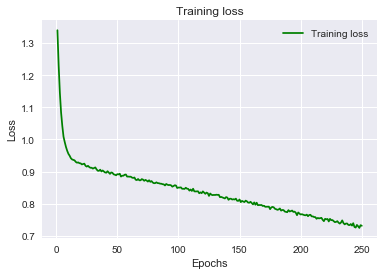

In [127]:
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

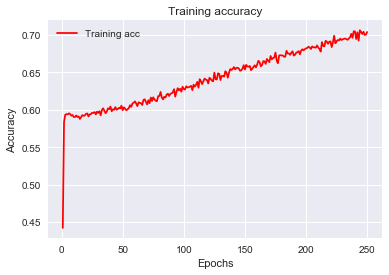

In [128]:
# Plot the training accuracy vs the number of epochs

acc_values = history_dict['acc'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Make predictions

In [129]:
# Output (probability) predictions for the test set 
y_hat_test = model.predict(X_test) 

In [130]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(X_train, y_train)
results_train

6819/6819 [==============================] - 1s 102us/step


[0.6809597329181526, 0.7310456078647606]

In [131]:
# Print the loss and accuracy for the test set 
results_test = model.evaluate(X_test, y_test)
results_test

2273/2273 [==============================] - 0s 72us/step


[0.8123432916006851, 0.6489221293444787]